In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf
from numpy import genfromtxt
from hmmlearn import hmm
from statsmodels.tsa.ar_model import AutoReg
np.random.seed(42)

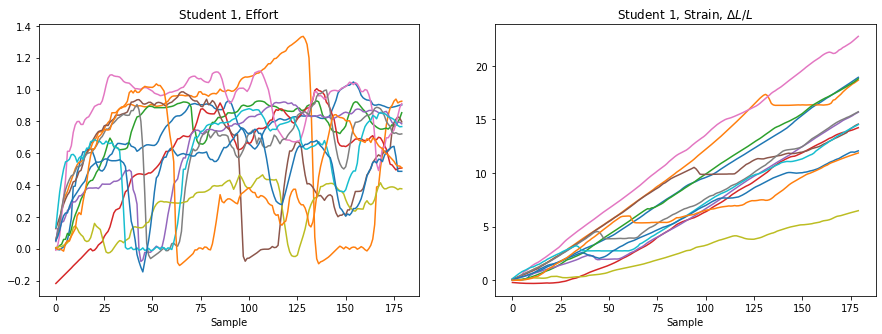

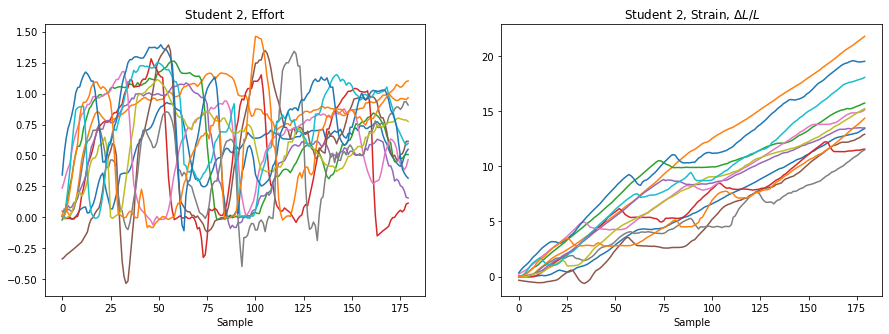

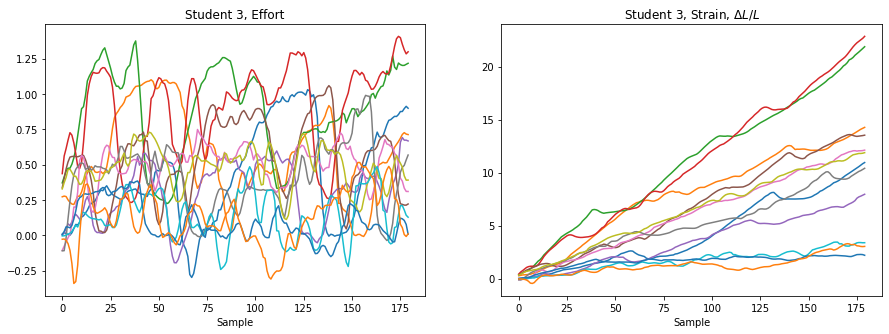

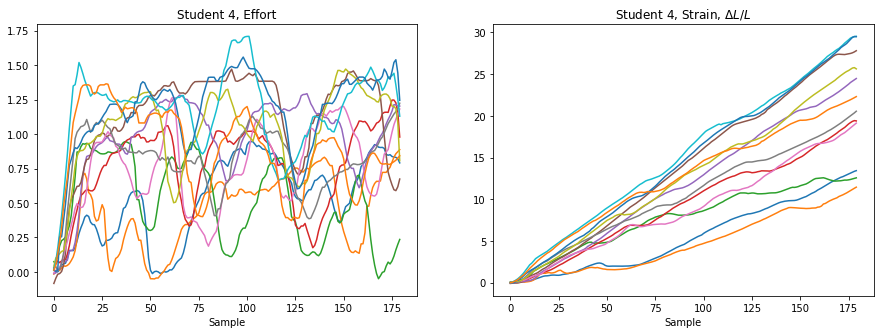

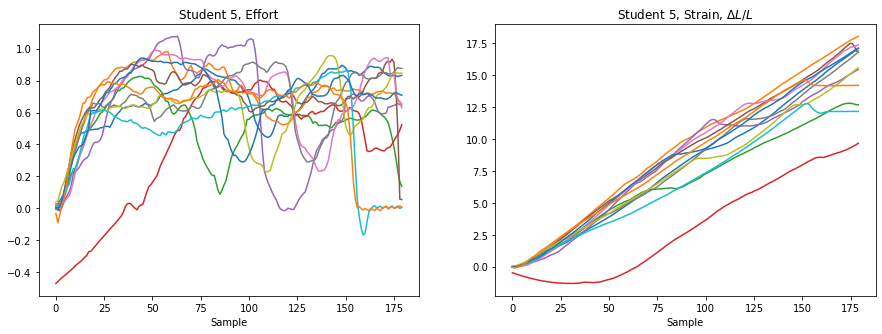

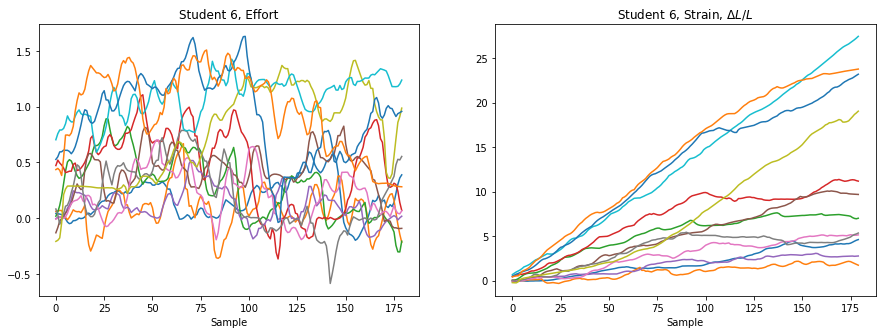

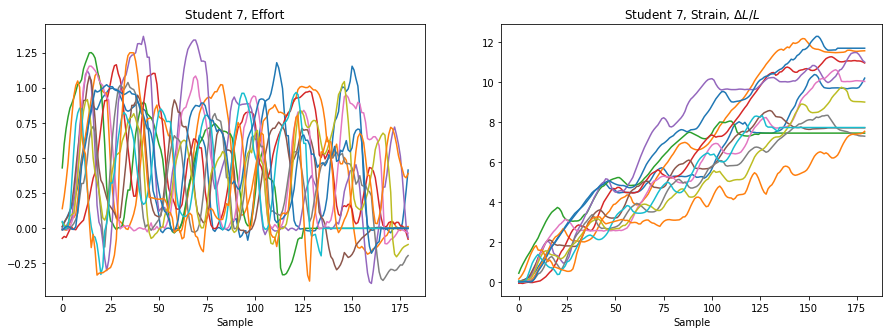

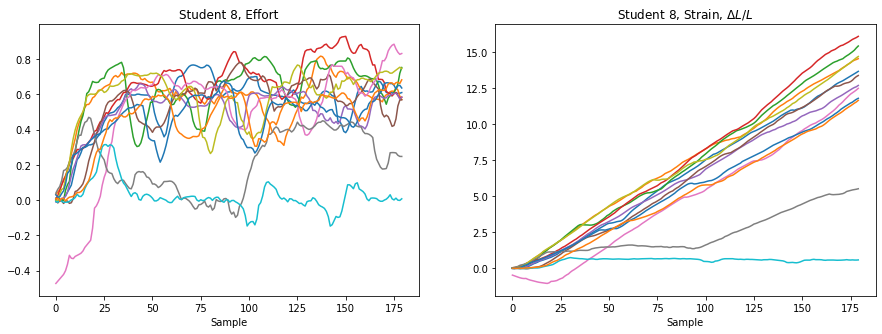

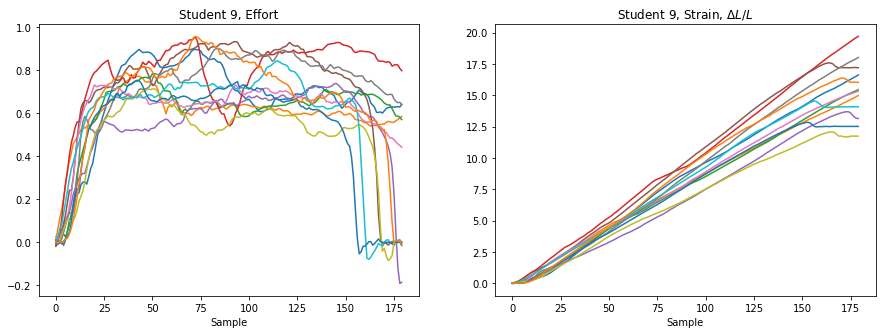

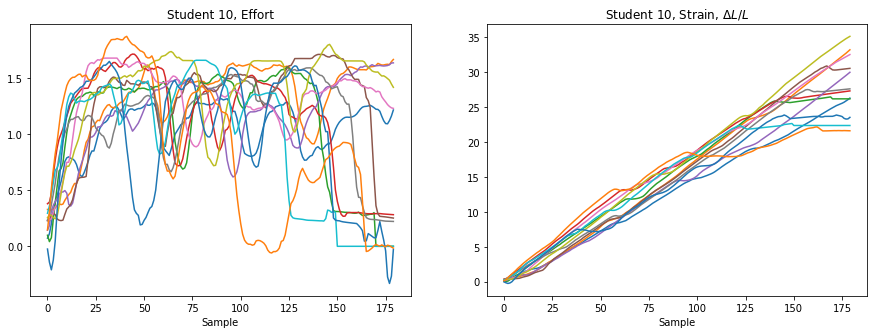

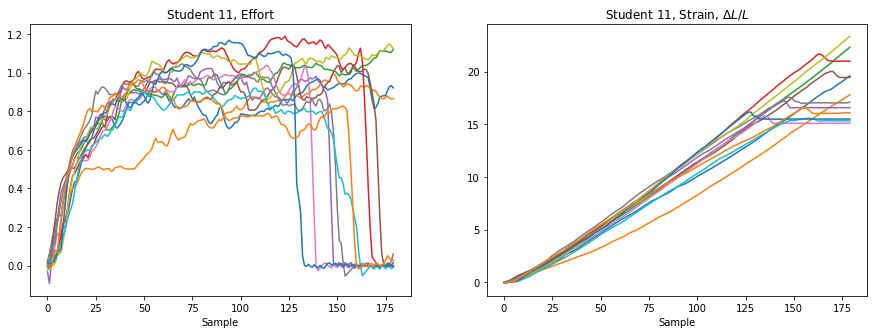

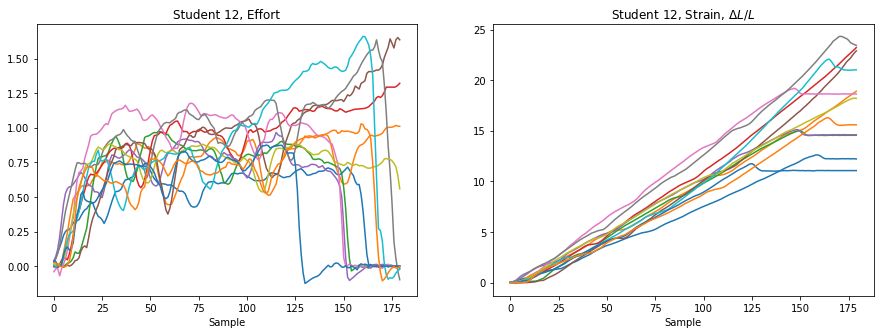

In [2]:
student_force = np.zeros([12,12,180]) # 12 students, 12 cuts, 180 samples
student_strain = np.zeros([12,12,180]) # 12 students, 12 cuts, 180 samples

for student in range(12):
    for cut in range(12):
        student_force[student,cut,:] = genfromtxt('./data/student_'+str(student+1)+'_force_'+str(cut+1)+'.csv', delimiter=',')
        student_strain[student,cut,:] = genfromtxt('./data/student_'+str(student+1)+'_strain_'+str(cut+1)+'.csv', delimiter=',')
        
for student in range(12):

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    for cut in range(12):
        plt.plot(student_force[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort')
    plt.xlabel('Sample')
    
    plt.subplot(1,2,2)
    for cut in range(12):
        plt.plot(student_strain[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain, $\Delta L/L$')
    plt.xlabel('Sample')


In [9]:
# Fit linear model 

bpts = 6 # number of breakpoints
x = np.arange(0,180)
student_strain_linear = np.zeros([12,12,180])
breakpoints = np.zeros([12,12,bpts+1])

for student in range(12):
    for cut in range(12):
        
        y = student_strain[student,cut,:]
        myPWLF = pwlf.PiecewiseLinFit(x,y)
        breakpoints[student,cut,:] = myPWLF.fit(bpts)
        xHat = np.linspace(min(x), max(x), num=180)
        yHat = myPWLF.predict(xHat)
        student_strain_linear[student,cut,:] = yHat

In [11]:
# # save linear strain model

# with open('./student_linear_strain.npy', 'wb') as f:
#     np.save(f, student_strain_linear)

# # Check
# with open('./student_linear_strain.npy', 'rb') as f:
#     test = np.load(f)    
# np.equal(test, student_strain_linear)



# # save breakpoints

# with open('./breakpoints.npy', 'wb') as f:
#     np.save(f, breakpoints)

# # Check
# with open('./breakpoints.npy', 'rb') as f:
#     test = np.load(f)    
# np.equal(test, breakpoints)

In [5]:
# Load linear model

with open('./student_linear_strain.npy', 'rb') as f:
    student_strain_linear = np.load(f)

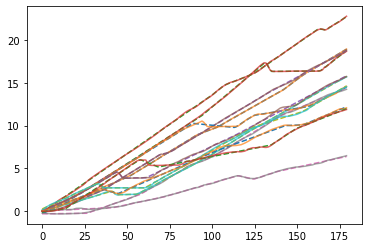

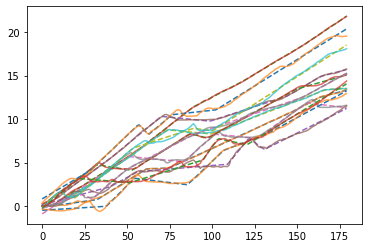

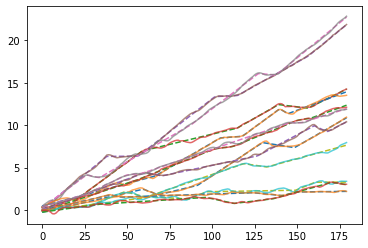

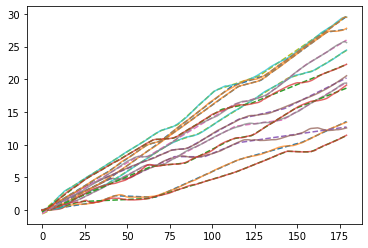

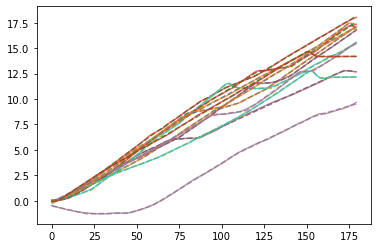

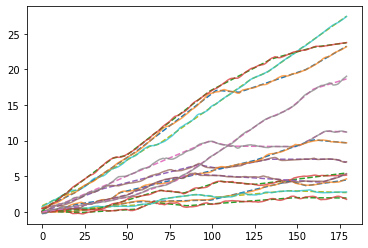

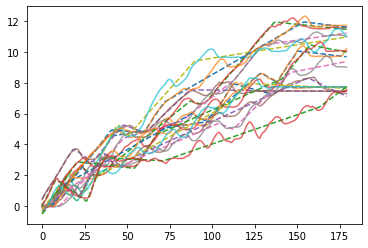

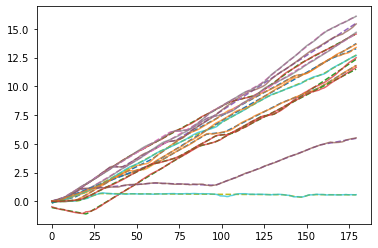

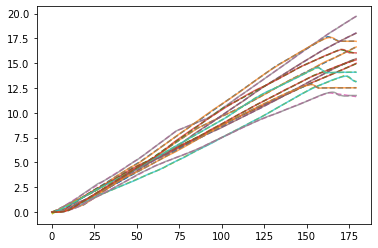

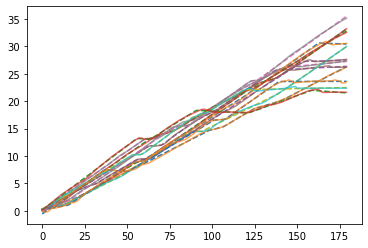

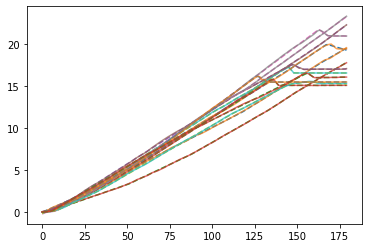

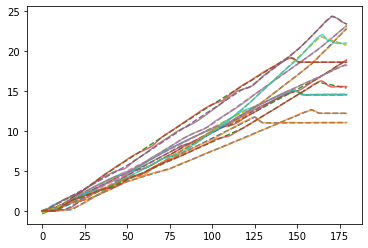

In [6]:
for student in range(12):
    for cut in range(12):
        plt.plot(student_strain_linear[student,cut,:],'--')
        plt.plot(student_strain[student,cut,:],alpha=0.7)
    plt.show()

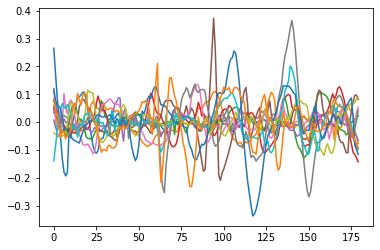

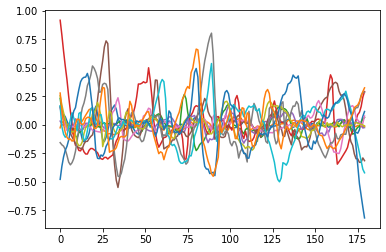

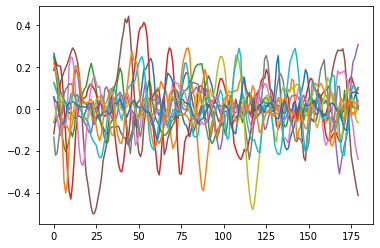

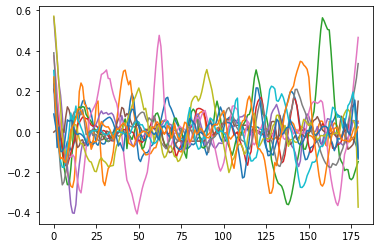

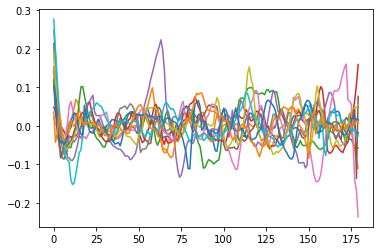

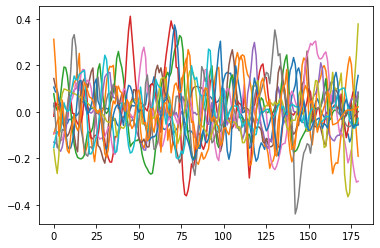

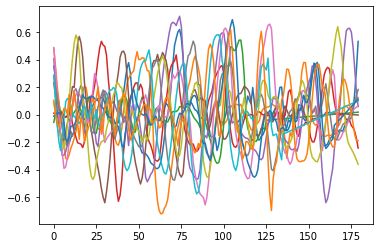

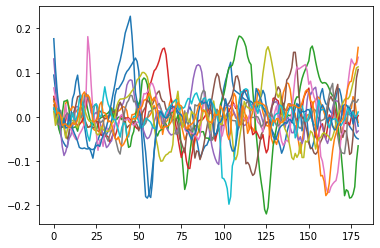

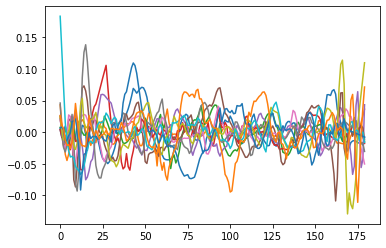

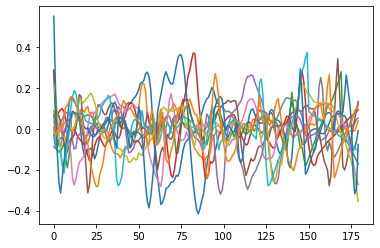

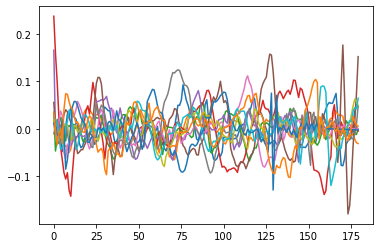

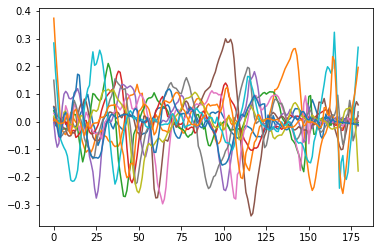

In [7]:
residuals = np.zeros([12,12,180])
for student in range(12):
    for cut in range(12):
        residuals[student,cut,:] = student_strain[student,cut,:] - student_strain_linear[student,cut,:]
        plt.plot(residuals[student,cut,:])
    plt.show()

In [302]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

In [888]:
ar_model = []

for student in range(12):

    res = residuals[student,0,:]
    for i in range(1,12):
        res = np.r_[res,residuals[student,i,:]]

    armodel = AutoReg(res, lags=4)
    armodel_fit = armodel.fit()
    # print(armodel_fit.summary())
    ar_model.append(armodel_fit)

C:\Users\honeycomb0\Miniconda3\envs\main\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\honeycomb0\Miniconda3\envs\main\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\honeycomb0\Miniconda3\envs\main\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
C:\Users\honeycomb0\Miniconda3\envs\main\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names t

In [1336]:
def generate_residuals(student,N=180,dt=0.0333):
    
    const = ar_model[student].params[0]
    arparams = ar_model[student].params[1:ar_model[student].params.shape[0]]
    maparams = np.zeros(ar_model[student].params.shape[0])

    ar = np.r_[1,-arparams]
    ma = np.r_[1,maparams]

    res = dt*arma_generate_sample(ar,ma,N)
    
    return res

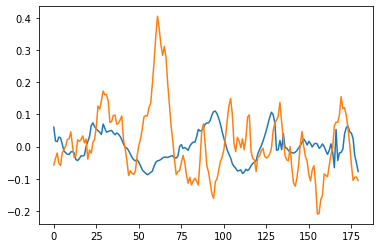

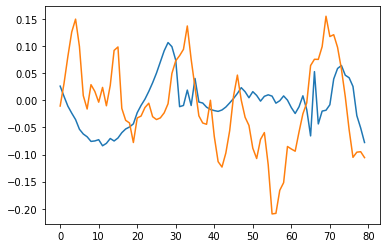

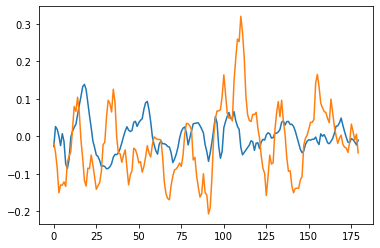

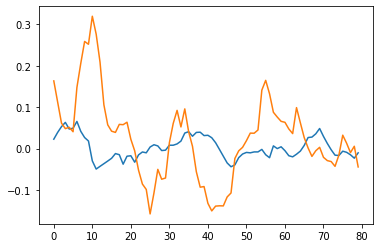

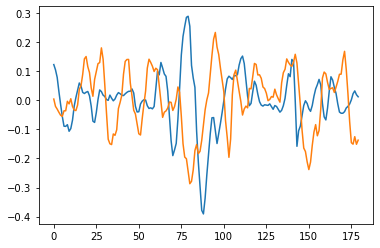

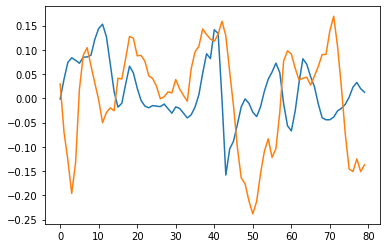

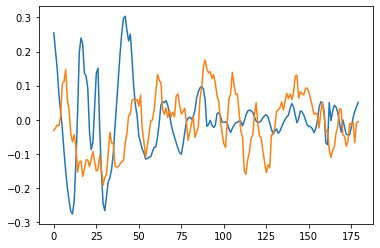

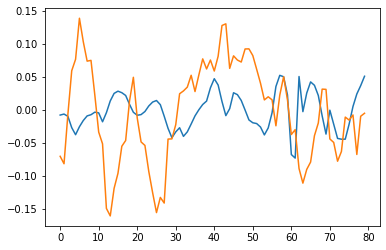

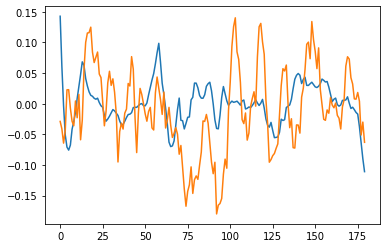

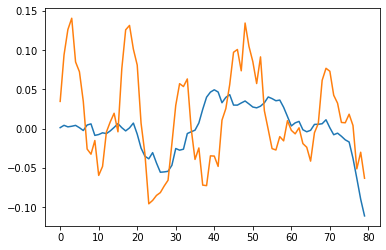

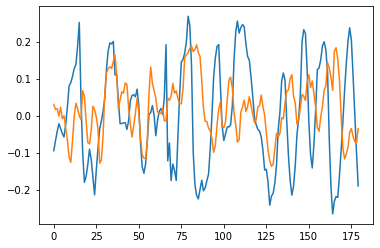

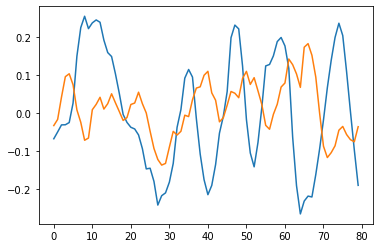

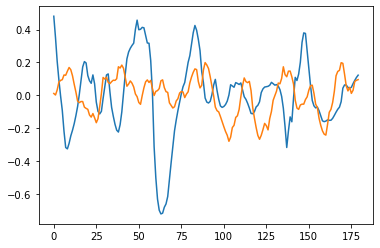

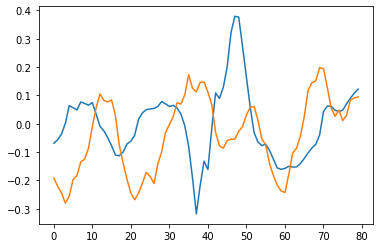

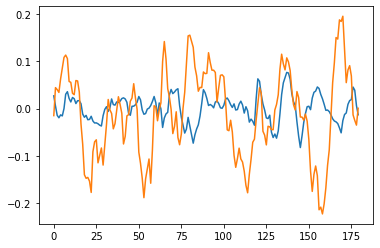

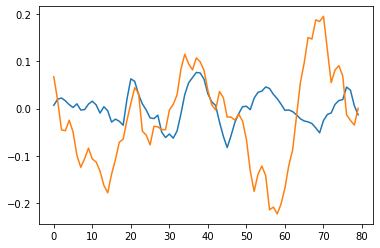

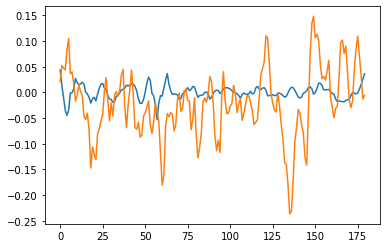

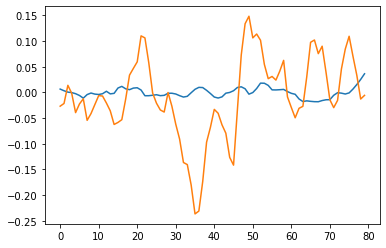

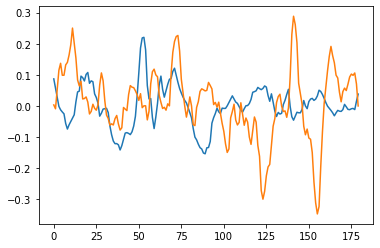

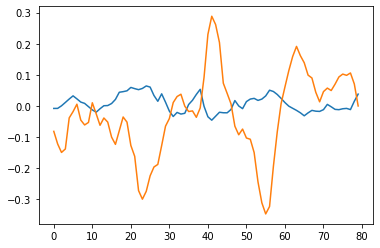

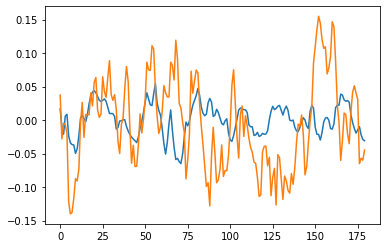

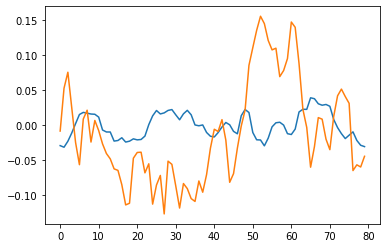

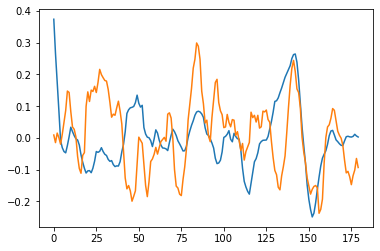

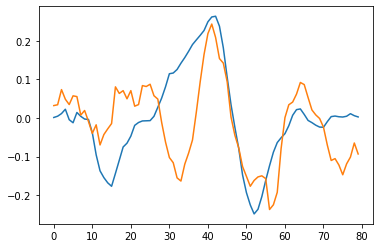

In [1338]:
for student in range(12):

    res = residuals[student,1,:]
    res_hat = generate_residuals(student)

    plt.plot(res)
    plt.plot(res_hat)
    plt.show()

    plt.plot(res[100:350])
    plt.plot(res_hat[100:350])
    plt.show()

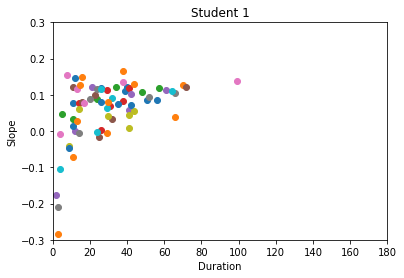

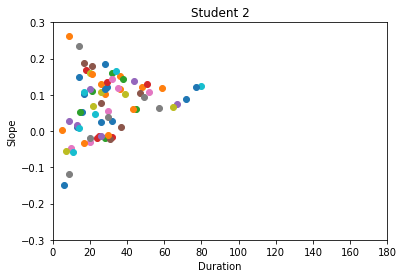

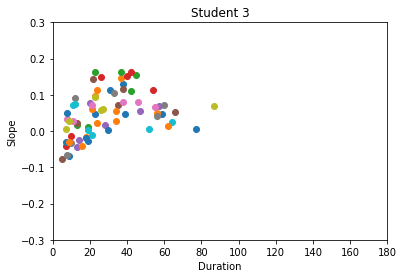

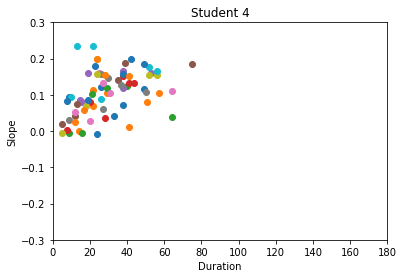

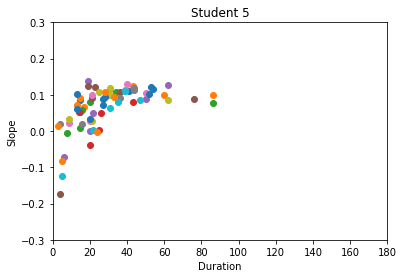

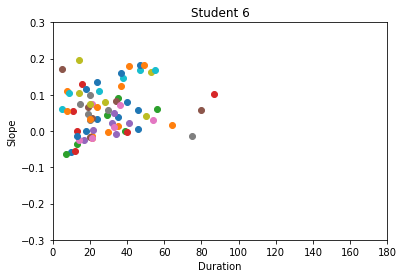

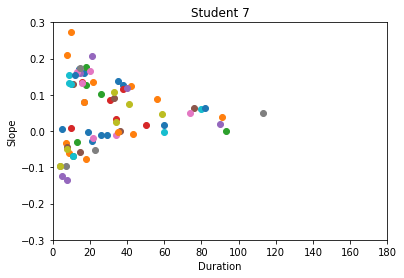

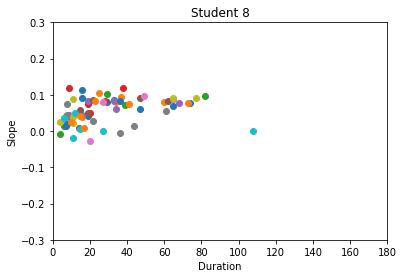

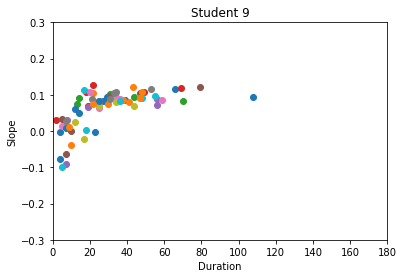

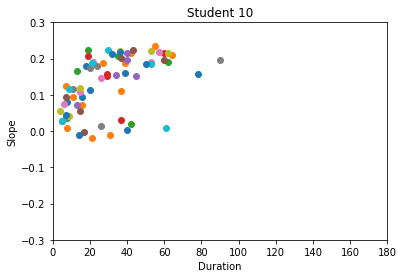

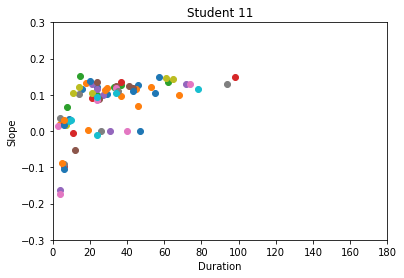

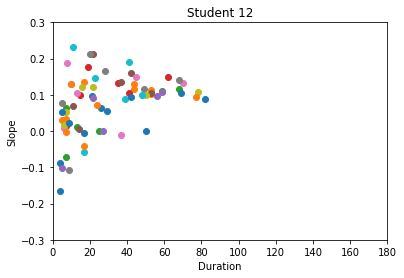

In [891]:
for student in range(12):
    
    for cut in range(12):
        
        slope = []
        duration = []
        
        indx = breakpoints[student,cut,:].astype(int)
        for i in range(1,7):
            slope.append(np.diff(student_strain_linear[student,cut,indx[i-1:i+1]])/np.diff(indx[i-1:i+1]))
            duration.append(np.diff(indx[i-1:i+1]))

        plt.scatter(np.array(duration),np.array(slope),label='Cut '+str(cut+1))

    plt.xlabel('Duration')
    plt.ylabel('Slope')
    plt.title('Student '+str(student+1))
    plt.xlim([0,180])
    plt.ylim([-0.3,0.3])
#     plt.legend()
    plt.show()

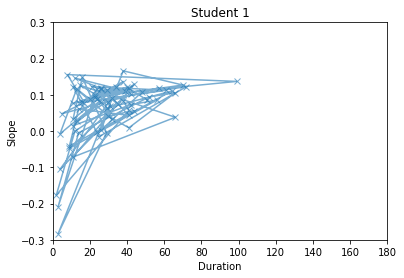

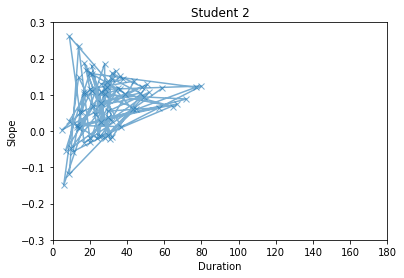

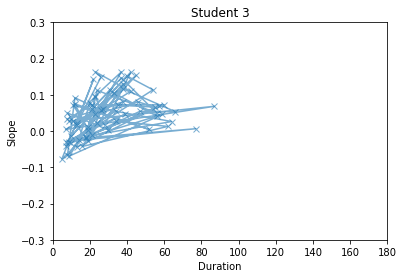

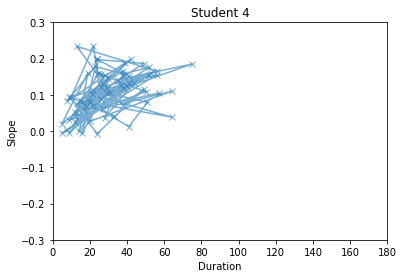

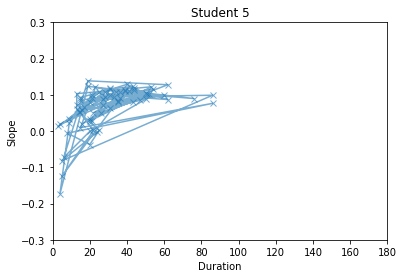

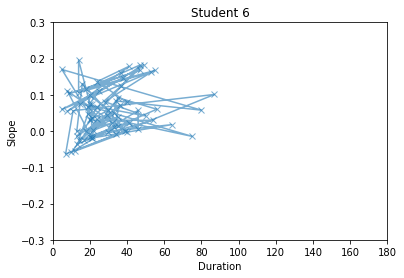

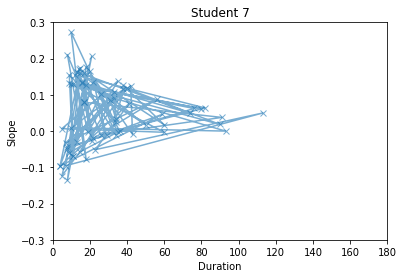

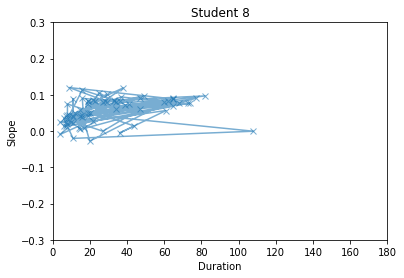

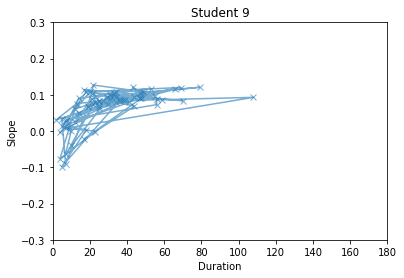

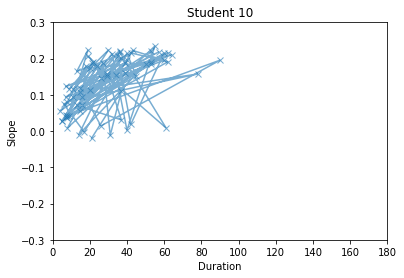

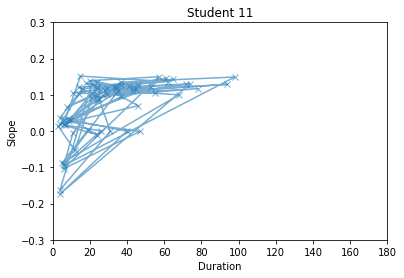

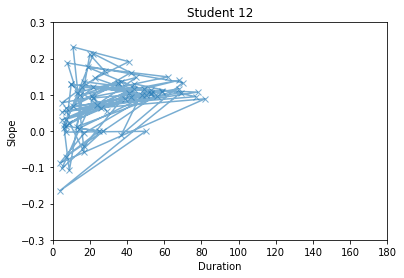

In [892]:
for student in range(12):

    slope = []
    duration = []
    
    for cut in range(12):
        
        indx = breakpoints[student,cut,:].astype(int)
        for i in range(1,7):
            slope.append(np.diff(student_strain_linear[student,cut,indx[i-1:i+1]])/np.diff(indx[i-1:i+1]))
            duration.append(np.diff(indx[i-1:i+1]))

    plt.plot(np.array(duration),np.array(slope),'-x',alpha=0.6)

    plt.xlabel('Duration')
    plt.ylabel('Slope')
    plt.title('Student '+str(student+1))
    plt.xlim([0,180])
    plt.ylim([-0.3,0.3])
    plt.show()

In [1296]:
mean_ = np.mean(sequence.reshape(-1,2),axis=0)
std_ = np.std(sequence.reshape(-1,2),axis=0)

In [1303]:
sequence = np.zeros([12,72,2]) # [student,12 cut x 6 linear segments, duration and slope]
sequence_norm = np.zeros([12,72,2])

for student in range(12):
    
    seq = []
    for cut in range(12):
        indx = breakpoints[student,cut,:].astype(int)
        for i in range(1,7):
            slope = np.diff(student_strain_linear[student,cut,indx[i-1:i+1]])/np.diff(indx[i-1:i+1])
            duration = np.diff(indx[i-1:i+1])
            seq.append(np.array([duration[0],slope[0]]))
    
    sequence[student,:,:] = np.array(seq)
    sequence_norm[student,:,:] = (np.array(seq) - mean_)/std_

In [1320]:
hmm_model = []

for student in range(12):
    
    model = hmm.GaussianHMM(n_components=4, covariance_type="full", n_iter=100)
#     model.fit(sequence[student,:,:])
#     model.fit(sequence[student,:,:], 6*np.ones(12,dtype='int32'))
    model.fit(sequence_norm[student,:,:], 6*np.ones(12,dtype='int32'))
    hmm_model.append(model)

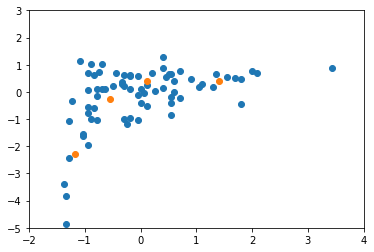

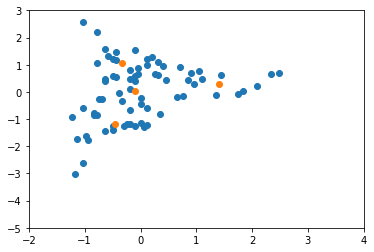

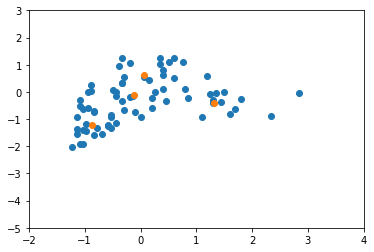

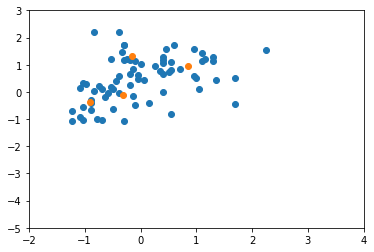

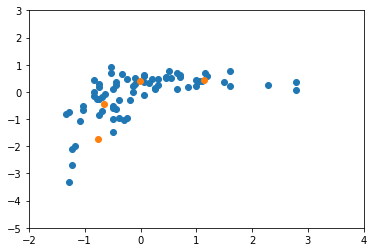

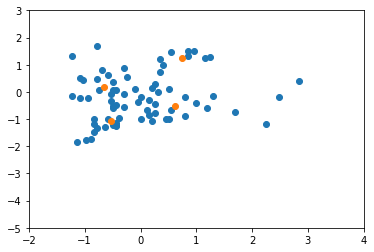

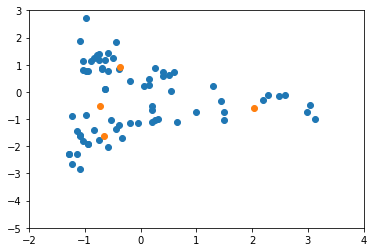

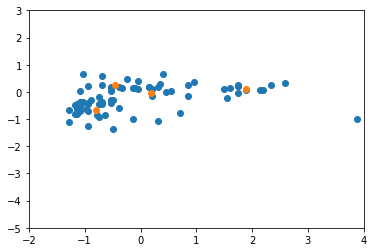

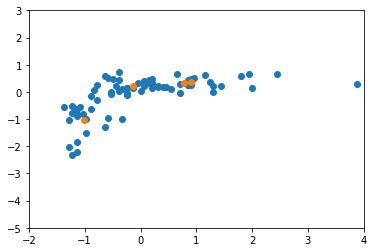

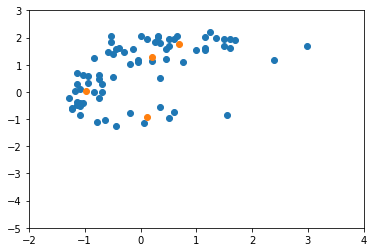

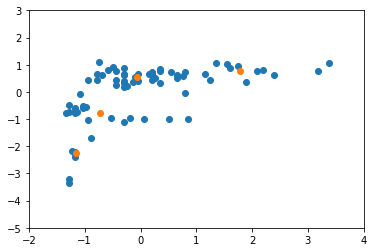

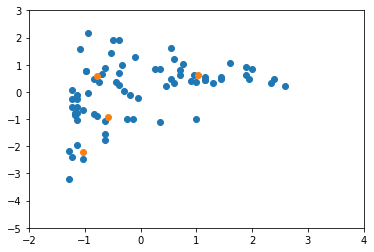

In [1321]:
for student in range(12):
    
#     plt.scatter(sequence[student,:,0],sequence[student,:,1])
    plt.scatter(sequence_norm[student,:,0],sequence_norm[student,:,1])
    plt.scatter(hmm_model[student].means_[:,0],hmm_model[student].means_[:,1])
    plt.xlim([-2,4])
    plt.ylim([-5,3])
    plt.show()

In [1307]:
def v2f(state,u,dt=0.0333):
    return state -4*state*dt + u*dt

def get_force(strain):
    
    dt = 0.0333
    forces = [0]
    resid = generate_residuals(4)
    strain_rate = np.diff(strain)

    for i in range(179):
        forces.append(v2f(forces[-1],(strain_rate[i]/dt)))
    
    return np.array(forces)

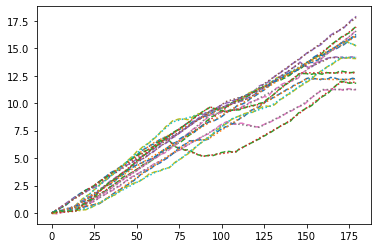

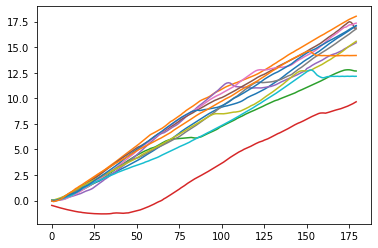

In [1583]:
cut = 6
for student in [4]:
    
    for i in range(12):

        X,Z = hmm_model[student].sample(6)
        X = (X * std_) + mean_

        indx = np.r_[0,np.cumsum(X[:,0].astype(int))]

        y = np.array([0])
        for i in range(indx.shape[0] - 1):
            y_ = np.arange(1,np.diff(indx)[i]) * X[i,1]
            y = np.concatenate((y, y_ + y[-1]))

        if y.shape[0] < 180:
            y_ = np.ones(180)*y[-1]
            y_[:y.shape[0]] = y
            y = y_

        res = generate_residuals(student)
        
        plt.plot(y[:180]+res,'--')
        plt.plot(y[:180],':')
    plt.show()
    
for cut in range(12):
    plt.plot(student_strain[student,cut,:])

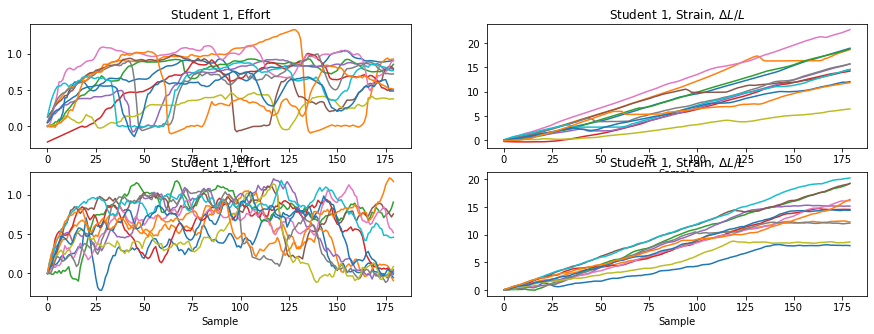

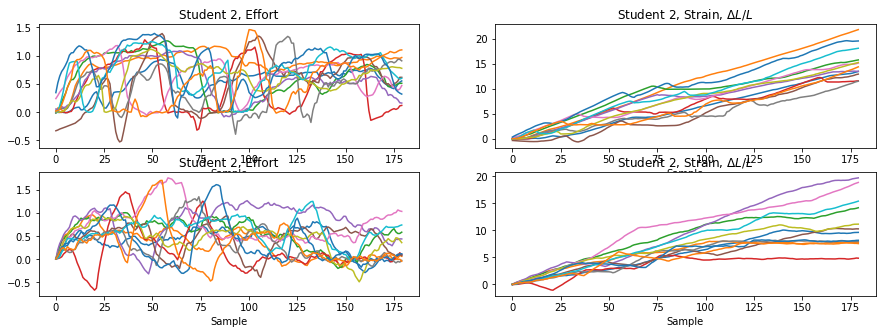

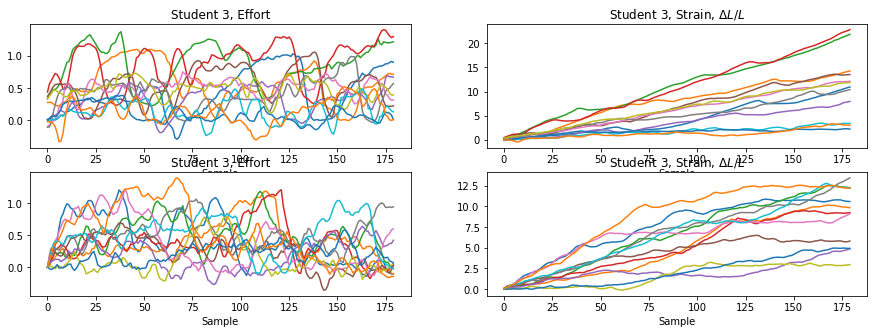

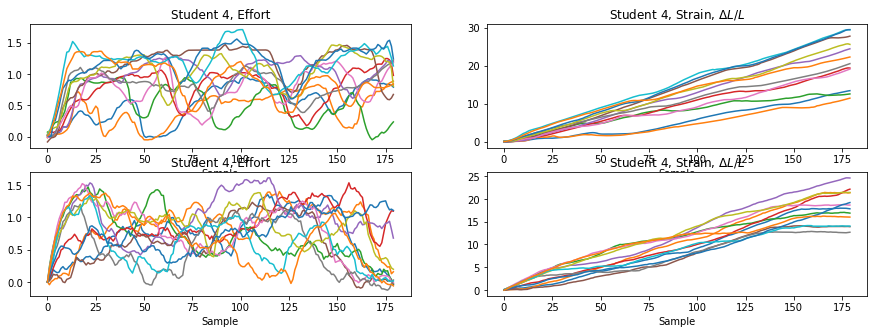

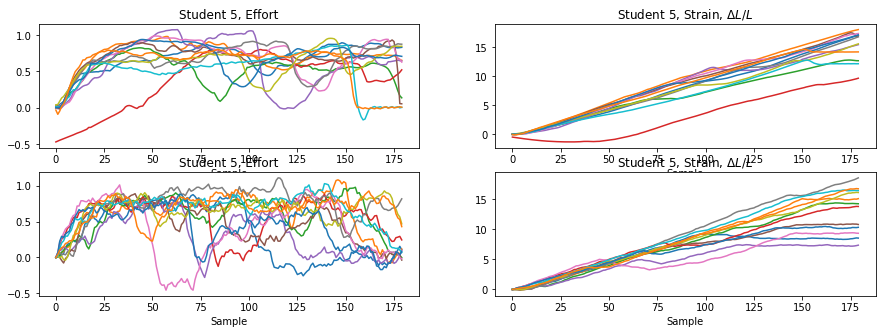

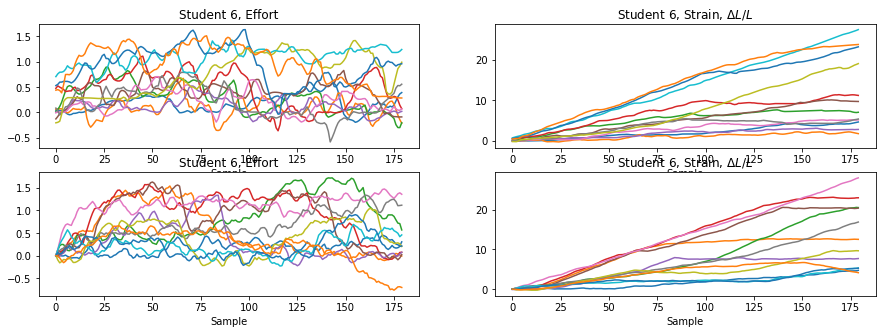

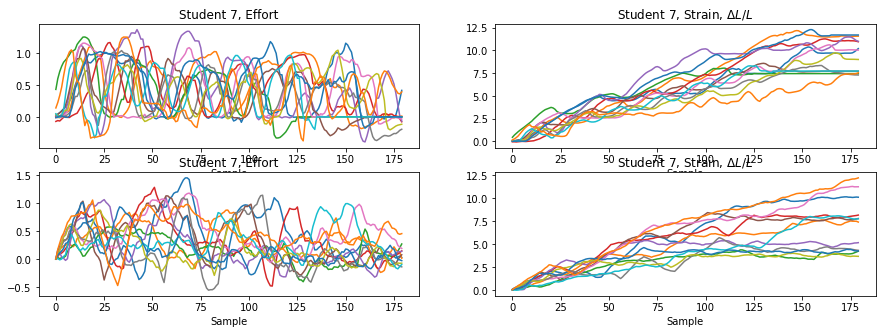

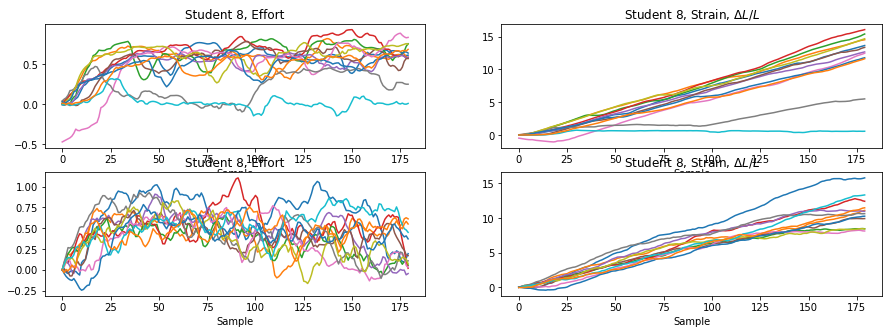

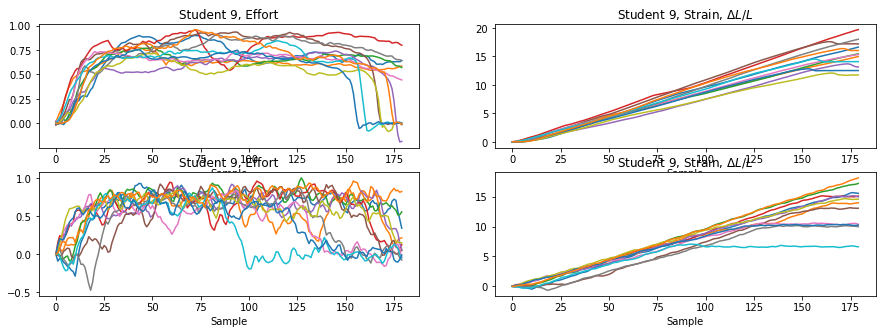

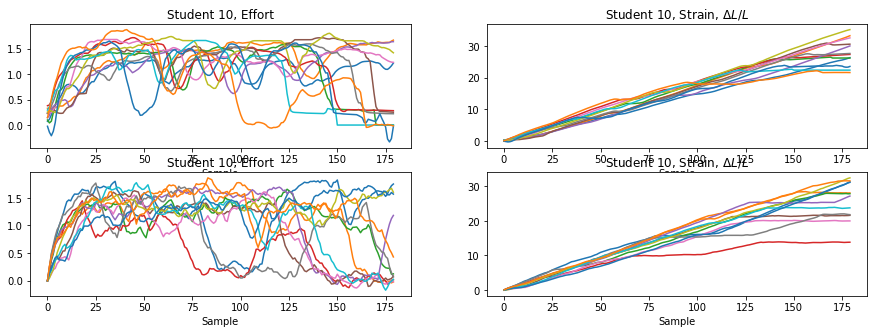

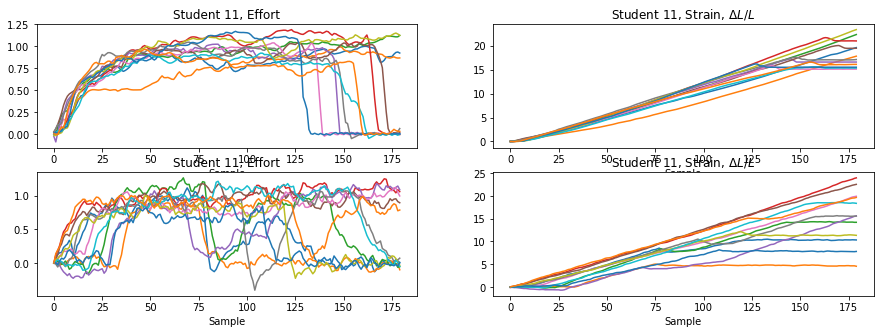

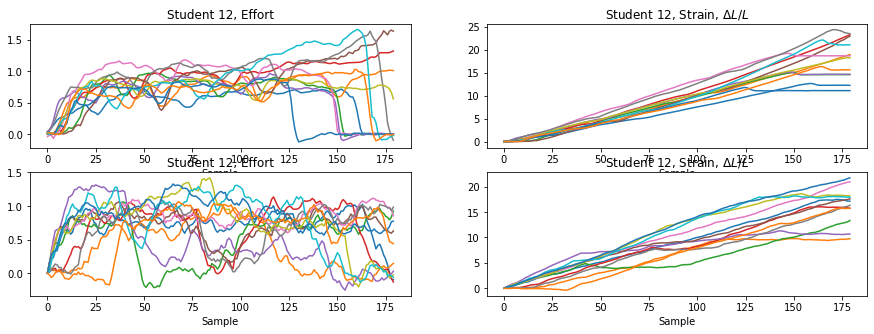

In [1585]:
student_strain_gen = np.zeros(student_strain.shape)
student_force_gen = np.zeros(student_force.shape)

for student in range(12):
    for cut in range(12):
    
        X,Z = hmm_model[student].sample(6)
        X = (X * std_) + mean_

        indx = np.r_[0,np.cumsum(X[:,0].astype(int))]

        y = np.array([0])
        for i in range(indx.shape[0] - 1):
            y_ = np.arange(1,np.diff(indx)[i]) * X[i,1]
            y = np.concatenate((y, y_ + y[-1]))

        if y.shape[0] < 180:
            y_ = np.ones(180)*y[-1]
            y_[:y.shape[0]] = y
            y = y_

        res = generate_residuals(student)
        
        student_strain_gen[student,cut,:] = y[:180]+res
        student_force_gen[student,cut,:] = get_force(y[:180]+res)    
        

for student in range(12):

    plt.figure(figsize=(15,5))
    
    plt.subplot(2,2,1)
    for cut in range(12):
        plt.plot(student_force[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,2)
    for cut in range(12):
        plt.plot(student_strain[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain, $\Delta L/L$')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,3)
    for cut in range(12):
        plt.plot(student_force_gen[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,4)
    for cut in range(12):
        plt.plot(student_strain_gen[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain, $\Delta L/L$')
    plt.xlabel('Sample')